<a href="https://colab.research.google.com/github/angelinakhatiwada/Urban-Sound-Classification/blob/main/FNN_RNN_CNN_Mels_(40_64).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Urban Sound Classification

## Classification

### Mels (40,64)



In [20]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1)

from sklearn.metrics import classification_report
import os

import pickle

In [64]:
# Libraries for Classification and building Models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, Flatten, Dense, MaxPool2D, Dropout, LSTM
from tensorflow.keras.utils import to_categorical 
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger

### Data import from pickle

In [3]:
with open('features_mels_40_64.p', 'rb') as f:
    data = pickle.load(f)

In [4]:
data.head()

,features,shape,num_frames,label,fold,file_name
0,"[[0.00021762802498415112, 0.000202349910978227...","(40, 64)",28,3,5,100032-3-0-0.wav
1,"[[0.0058693523, 0.013092514, 0.03987947, 0.021...","(40, 64)",345,2,5,100263-2-0-117.wav
2,"[[0.005688955, 0.027750378, 0.04978776, 0.0287...","(40, 64)",345,2,5,100263-2-0-121.wav
3,"[[0.050584998, 0.036760394, 0.020823054, 0.022...","(40, 64)",345,2,5,100263-2-0-126.wav
4,"[[0.03850708, 0.02781331, 0.04098259, 0.026116...","(40, 64)",345,2,5,100263-2-0-137.wav


In [5]:
data_final = pd.DataFrame(data['label'])
data_final['fold'] = data['fold']
data_final['features'] = data['features']

print('working dataframe\'s shape:', data_final.shape)
data_final.head()

working dataframe's shape: (8732, 3)


,label,fold,features
0,3,5,"[[0.00021762802498415112, 0.000202349910978227..."
1,2,5,"[[0.0058693523, 0.013092514, 0.03987947, 0.021..."
2,2,5,"[[0.005688955, 0.027750378, 0.04978776, 0.0287..."
3,2,5,"[[0.050584998, 0.036760394, 0.020823054, 0.022..."
4,2,5,"[[0.03850708, 0.02781331, 0.04098259, 0.026116..."


In [6]:
dummies = pd.get_dummies(data_final['label']).rename(columns=lambda x: 'label_' + str(x))
data_final = pd.concat([data_final, dummies], axis=1)
data_final.drop(['label'], inplace=True, axis=1)
data_final.head()

,fold,features,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8,label_9
0,5,"[[0.00021762802498415112, 0.000202349910978227...",0,0,0,1,0,0,0,0,0,0
1,5,"[[0.0058693523, 0.013092514, 0.03987947, 0.021...",0,0,1,0,0,0,0,0,0,0
2,5,"[[0.005688955, 0.027750378, 0.04978776, 0.0287...",0,0,1,0,0,0,0,0,0,0
3,5,"[[0.050584998, 0.036760394, 0.020823054, 0.022...",0,0,1,0,0,0,0,0,0,0
4,5,"[[0.03850708, 0.02781331, 0.04098259, 0.026116...",0,0,1,0,0,0,0,0,0,0


In [7]:
def df_transform(fold):
  X_fold_df = data_final[data_final['fold'].isin(fold)]
  list_arrays = list(X_fold_df['features'])
  X = np.stack(list_arrays, axis=0 )
  y = X_fold_df.iloc[:, 2:12].to_numpy()

  return X, y

In [79]:
X_train, y_train = df_transform(['1', '2', '3', '4', '6'])
X_train.shape, y_train.shape

((4499, 40, 64), (4499, 10))

In [80]:
X_val, y_val = df_transform(['5'])
X_val.shape, y_val.shape

((936, 40, 64), (936, 10))

In [81]:
X_test7, y_test7 = df_transform(['7'])
X_test8, y_test8 = df_transform(['8'])
X_test9, y_test9 = df_transform(['9'])
X_test10, y_test10 = df_transform(['10'])

## Classification

In [11]:
def plot_accuracy(history):
  #accuracy
  plt.figure(figsize=(8,3))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  #loss
  plt.figure(figsize=(8,3))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [93]:
def test_scores(model):
  score5 = model.evaluate(X_val, y_val)
  score7 = model.evaluate(X_test7, y_test7)
  score8 = model.evaluate(X_test8, y_test8)
  score9 = model.evaluate(X_test9, y_test9)
  score10 = model.evaluate(X_test10, y_test10)
  test_scores = [score5[1],score7[1],score8[1],score9[1],score10[1]]
  
  return test_scores

### CNN model

In [82]:
# reshaping
X_train = X_train.reshape(X_train.shape[0],40,64,1)
X_val = X_val.reshape(X_val.shape[0],40,64,1)
X_test7 = X_test7.reshape(X_test7.shape[0],40,64,1)
X_test8 = X_test8.reshape(X_test8.shape[0],40,64,1)
X_test9 = X_test9.reshape(X_test9.shape[0],40,64,1)
X_test10 = X_test10.reshape(X_test10.shape[0],40,64,1)

In [83]:
#shapes
X_train.shape, X_val.shape

((4499, 40, 64, 1), (936, 40, 64, 1))

In [85]:
model = Sequential()
input_dim = (40, 64, 1)

model.add(Conv2D(64, (3, 3), padding = "same", activation = "relu", input_shape = input_dim))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.2))

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(10, activation = "softmax"))

model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 40, 64, 64)        640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 20, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 20, 32, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 10, 16, 128)      0         
 2D)                                                             
                                                                 
 dropout_35 (Dropout)        (None, 10, 16, 128)       0         
                                                                 
 flatten_3 (Flatten)         (None, 20480)           

In [86]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [87]:
history = model.fit(X_train, y_train, epochs =15, batch_size = 128, validation_data =(X_val, y_val), verbose =True)

Epoch 1/15
36/36 [==============================] - 45s 1s/step - loss: 2.6608 - accuracy: 0.2220 - val_loss: 2.0590 - val_accuracy: 0.1709
Epoch 2/15
36/36 [==============================] - 44s 1s/step - loss: 1.8419 - accuracy: 0.3570 - val_loss: 1.9217 - val_accuracy: 0.3515
Epoch 3/15
36/36 [==============================] - 44s 1s/step - loss: 1.5428 - accuracy: 0.4592 - val_loss: 1.9419 - val_accuracy: 0.3750
Epoch 4/15
36/36 [==============================] - 45s 1s/step - loss: 1.3798 - accuracy: 0.5190 - val_loss: 1.9785 - val_accuracy: 0.3900
Epoch 5/15
36/36 [==============================] - 44s 1s/step - loss: 1.2760 - accuracy: 0.5532 - val_loss: 2.1570 - val_accuracy: 0.3835
Epoch 6/15
36/36 [==============================] - 45s 1s/step - loss: 1.1799 - accuracy: 0.5986 - val_loss: 1.9826 - val_accuracy: 0.4498
Epoch 7/15
36/36 [==============================] - 43s 1s/step - loss: 1.0662 - accuracy: 0.6384 - val_loss: 2.1949 - val_accuracy: 0.4573
Epoch 8/15
36/36 [==

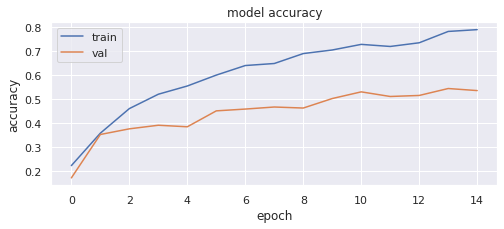

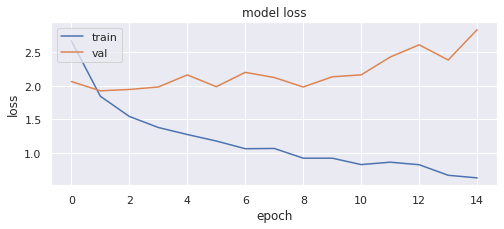

In [95]:
plot_accuracy(history)

In [97]:
test_scores_cnn = test_scores(model)
test_scores_cnn

27/27 [==============================] - 2s 85ms/step - loss: 2.3214 - accuracy: 0.5627


[0.5341880321502686,
 0.4964200556278229,
 0.5645161271095276,
 0.4803921580314636,
 0.5627239942550659]

In [98]:
print((np.mean(test_scores_cnn), np.std(test_scores_cnn)))

(0.5276480734348297, 0.03417793235382256)


### FNN

In [31]:
# data reshaping for NN
X_train = X_train.reshape(X_train.shape[0], 2560)
X_val = X_val.reshape(X_val.shape[0],2560)
X_test7 = X_test7.reshape(X_test7.shape[0],2560)
X_test8 = X_test8.reshape(X_test8.shape[0],2560)
X_test9 = X_test9.reshape(X_test9.shape[0],2560)
X_test10 = X_test10.reshape(X_test10.shape[0],2560)

In [50]:
#forming model
model=Sequential()
#building the model
model.add(Dense(units=1024,activation='relu',input_dim=2560))
model.add(Dropout(0.2))
model.add(Dense(units=512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=10,activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 1024)              2622464   
                                                                 
 dropout_22 (Dropout)        (None, 1024)              0         
                                                                 
 dense_27 (Dense)            (None, 512)               524800    
                                                                 
 dropout_23 (Dropout)        (None, 512)               0         
                                                                 
 dense_28 (Dense)            (None, 128)               65664     
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                                                                 
 dense_29 (Dense)            (None, 64)               

In [51]:
#compiling
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [52]:
history = model.fit(X_train,y_train,epochs=30 ,batch_size=64, validation_data = (X_val, y_val))

Epoch 1/30
71/71 [==============================] - 4s 44ms/step - loss: 4.4853 - accuracy: 0.1671 - val_loss: 2.4245 - val_accuracy: 0.2361
Epoch 2/30
71/71 [==============================] - 3s 45ms/step - loss: 2.9785 - accuracy: 0.2158 - val_loss: 2.2780 - val_accuracy: 0.2788
Epoch 3/30
71/71 [==============================] - 3s 43ms/step - loss: 2.5374 - accuracy: 0.2498 - val_loss: 2.1329 - val_accuracy: 0.2756
Epoch 4/30
71/71 [==============================] - 3s 41ms/step - loss: 2.2652 - accuracy: 0.2938 - val_loss: 2.0209 - val_accuracy: 0.2714
Epoch 5/30
71/71 [==============================] - 3s 43ms/step - loss: 2.0817 - accuracy: 0.3372 - val_loss: 2.0770 - val_accuracy: 0.2949
Epoch 6/30
71/71 [==============================] - 3s 43ms/step - loss: 2.0543 - accuracy: 0.3487 - val_loss: 2.0593 - val_accuracy: 0.3173
Epoch 7/30
71/71 [==============================] - 3s 39ms/step - loss: 2.0113 - accuracy: 0.3690 - val_loss: 2.0031 - val_accuracy: 0.2682
Epoch 8/30
71

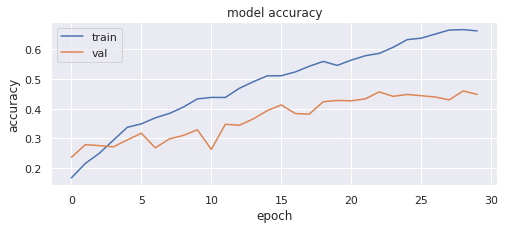

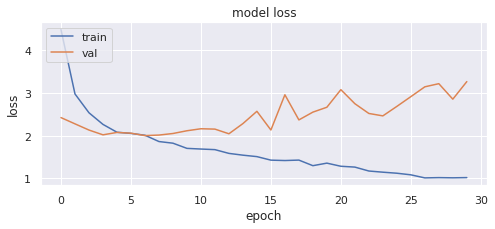

In [53]:
plot_accuracy(history)

In [56]:
test_scores_fnn = test_scores(model)
test_scores_fnn

27/27 [==============================] - 0s 11ms/step - loss: 3.5794 - accuracy: 0.4540


[0.4476495683193207,
 0.4093078672885895,
 0.5359801650047302,
 0.3958333432674408,
 0.45400238037109375]

In [57]:
print((np.mean(test_scores_fnn), np.std(test_scores_fnn))) 

(0.448554664850235, 0.04897665515257511)


### RNN

In [61]:
X_train.shape

(4499, 40, 64)

In [62]:
X_train_T = np.transpose(X_train, (0,2,1))
X_val_T = np.transpose(X_val, (0,2,1))
X_test7 = np.transpose(X_test7, (0,2,1))
X_test8 = np.transpose(X_test8, (0,2,1))
X_test9 = np.transpose(X_test9, (0,2,1))
X_test10 = np.transpose(X_test10, (0,2,1))
X_train_T.shape, X_val_T.shape

((4499, 64, 40), (936, 64, 40))

In [68]:
# Neural network model
input_shape = (64,40)

model = Sequential()
model.add(LSTM(64,input_shape=input_shape, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(24, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                26880     
                                                                 
 dense_35 (Dense)            (None, 64)                4160      
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                                 
 dense_36 (Dense)            (None, 32)                2080      
                                                                 
 dropout_30 (Dropout)        (None, 32)                0         
                                                                 
 dense_37 (Dense)            (None, 24)                792       
                                                                 
 dropout_31 (Dropout)        (None, 24)               

In [70]:
#compiling
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [71]:
history = model.fit(X_train_T,y_train,epochs=50 ,batch_size=256, validation_data = (X_val_T, y_val))

Epoch 1/50
18/18 [==============================] - 8s 265ms/step - loss: 2.2714 - accuracy: 0.1560 - val_loss: 2.2383 - val_accuracy: 0.1709
Epoch 2/50
18/18 [==============================] - 4s 236ms/step - loss: 2.1498 - accuracy: 0.2087 - val_loss: 2.2038 - val_accuracy: 0.1603
Epoch 3/50
18/18 [==============================] - 4s 245ms/step - loss: 2.0612 - accuracy: 0.2507 - val_loss: 2.1759 - val_accuracy: 0.2105
Epoch 4/50
18/18 [==============================] - 4s 234ms/step - loss: 1.9736 - accuracy: 0.2905 - val_loss: 2.1649 - val_accuracy: 0.2286
Epoch 5/50
18/18 [==============================] - 4s 234ms/step - loss: 1.9168 - accuracy: 0.3065 - val_loss: 2.1366 - val_accuracy: 0.2415
Epoch 6/50
18/18 [==============================] - 5s 251ms/step - loss: 1.8626 - accuracy: 0.3281 - val_loss: 2.1535 - val_accuracy: 0.2393
Epoch 7/50
18/18 [==============================] - 4s 242ms/step - loss: 1.8344 - accuracy: 0.3385 - val_loss: 2.0973 - val_accuracy: 0.2671
Epoch 

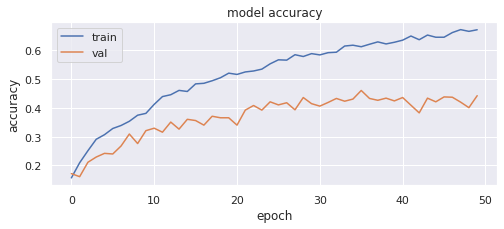

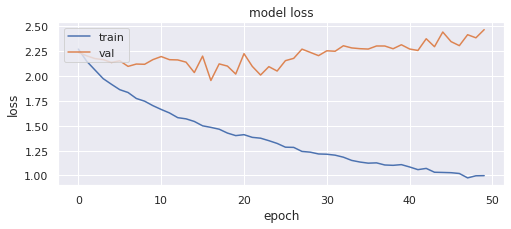

In [72]:
plot_accuracy(history)

In [75]:
score5 = model.evaluate(X_val_T, y_val)
score7 = model.evaluate(X_test7, y_test7)
score8 = model.evaluate(X_test8, y_test8)
score9 = model.evaluate(X_test9, y_test9)
score10 = model.evaluate(X_test10, y_test10)
test_scores = [score5[1],score7[1],score8[1],score9[1],score10[1]]
test_scores

27/27 [==============================] - 0s 15ms/step - loss: 1.9872 - accuracy: 0.4432


[0.4423076808452606,
 0.42601433396339417,
 0.48263028264045715,
 0.38848039507865906,
 0.4432497024536133]

In [77]:
print((np.mean(test_scores), np.std(test_scores)))

(0.43653647899627684, 0.030407616190514627)
